# Plots for experiments

In [2]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils
import data


In [3]:
%matplotlib inline
sns.set()
np.random.seed(1)
np.set_printoptions(precision=6, suppress=True)


Model (depth=4): 2019-08-11 20:55:14 dataset=fmnist_sandal_sneaker weak_learner=tree model=robust_bound n_train=-1 n_trials_coord=784 eps=0.000 max_depth=4 lr=0.2
iter: 95/150 eps=0.000 [test] err 1.80% adv_err_lb 1.80% adv_err 1.80%  adv_err_ub 1.80%  |  [valid] err 2.00% adv_err_lb 2.00% adv_err 2.00%  |  [train] err: 0.00%  adv_err: 0.00%  loss: 0.00630 (335.33 min)
Model (depth=4): 2019-08-11 20:55:14 dataset=fmnist_sandal_sneaker weak_learner=tree model=robust_bound n_train=-1 n_trials_coord=784 eps=0.020 max_depth=4 lr=0.2
iter: 115/150 eps=0.020 [test] err 1.35% adv_err_lb 2.15% adv_err 2.30%  adv_err_ub 2.30%  |  [valid] err 1.83% adv_err_lb 3.08% adv_err 3.25%  |  [train] err: 0.02%  adv_err: 0.04%  loss: 0.01295 (512.17 min)
Model (depth=4): 2019-08-11 20:55:14 dataset=fmnist_sandal_sneaker weak_learner=tree model=robust_bound n_train=-1 n_trials_coord=784 eps=0.040 max_depth=4 lr=0.2
iter: 133/150 eps=0.040 [test] err 1.55% adv_err_lb 3.25% adv_err 3.85%  adv_err_ub 3.85%  |

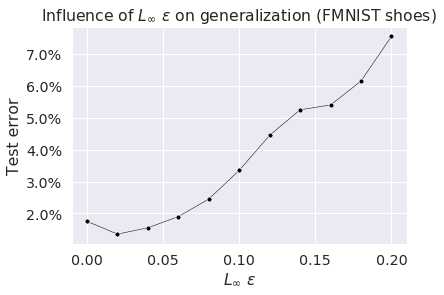

In [9]:
dataset = 'fmnist_sandal_sneaker'  # diabetes, cod_rna, fmnist_sandal_sneaker
model = 'robust_bound'
exp_folder = 'exps_generalization'
weak_learner = 'tree'
tree_depth = 4
model_names = utils.get_model_names([dataset], [model], exp_folder, weak_learner, tree_depth)
# ignore the date and time while sorting
model_names = sorted(model_names, key=lambda s: s.split('dataset')[1])

all_epss, all_test_errs = [], []
latex_table, latex_str = '', ''
for i, model_name in enumerate(model_names):
    dataset = model_name.split('dataset=')[1].split(' ')[0]
    model = model_name.split('model=')[1].split(' ')[0]
    eps = model_name.split('eps=')[1].split(' ')[0]
    max_depth = model_name.split('max_depth=')[1].split(' ')[0]
    print('Model (depth={}): {}'.format(max_depth, model_name))
    
    metrics_path = model_name + '.metrics'
    metrics = np.loadtxt(exp_folder + '/' + metrics_path)
    
    # needed for plots
    iters = metrics[:, 0]
    test_errs, test_adv_errs = metrics[:, 1], metrics[:, 3]
    train_errs, train_adv_errs = metrics[:, 5], metrics[:, 6]
    train_losses = metrics[:, 7]
    valid_errs, valid_adv_errs_lb, valid_adv_errs = metrics[:, 8], metrics[:, 9], metrics[:, 10]
    
    # Model selection is done
    iter_to_print = np.argmin(test_errs)
    
    last_iter, n_iter_done, time_total = int(metrics[iter_to_print, 0]), len(metrics[:, 0]), metrics[-1, 12]
    test_err, test_adv_err_lb, test_adv_err, test_adv_err_ub = metrics[iter_to_print, 1:5]
    train_err, train_adv_err, train_loss = metrics[iter_to_print, 5:8]
    valid_err, valid_adv_err_lb, valid_adv_err, valid_adv_err_ub = metrics[iter_to_print, 8:12]

    test_str = 'iter: {}/{} eps={} [test] err {:.2%} adv_err_lb {:.2%} adv_err {:.2%}  adv_err_ub {:.2%}'.format(
        last_iter, n_iter_done, eps, test_err, test_adv_err_lb, test_adv_err, test_adv_err_ub)
    valid_str = '[valid] err {:.2%} adv_err_lb {:.2%} adv_err {:.2%}'.format(
        valid_err, valid_adv_err_lb, valid_adv_err)
    train_str = '[train] err: {:.2%}  adv_err: {:.2%}  loss: {:.5f}'.format(
        train_err, train_adv_err, train_loss)
    all_test_errs.append(test_err)
    all_epss.append(float(eps))
    print('{}  |  {}  |  {} ({:.2f} min)'.format(test_str, valid_str, train_str, time_total/60)) 

# To make sure that the numbers for eps=0 match the ones from the big table
# They need not match, because robust_bound models get essentially a different random seed
eps0_te_dict = {4: {'diabetes': 0.2273, 'cod_rna': 0.0341, 'fmnist_sandal_sneaker': 0.0175},
                8: {'diabetes': 0.2208, 'cod_rna': 0.0323, 'fmnist_sandal_sneaker': 0.0185}}
all_test_errs[0] = eps0_te_dict[tree_depth][dataset]

sns.set(font_scale=1.3)
dataset_official = data.dataset_names_dict[dataset]
plot_name_short = 'Influence of $L_\infty$ $\epsilon$ on generalization ({})'.format(dataset_official)
plot_name_long = 'robustness_generalization-dataset={}-model={}-depth={}'.format(
    dataset, model, tree_depth)

marker_size, line_width = 5.0, 0.5
ax = sns.lineplot(all_epss, all_test_errs, linewidth=line_width, 
                  marker='o', markersize=marker_size, color="black")

ax.set_yticklabels(['{:.1%}'.format(x) for x in ax.get_yticks()])
ax.set_xlabel('$L_\infty$ $\epsilon$')
ax.set_ylabel('Test error')
# ax.legend(loc='best', prop={'size': 12})
ax.set_title(plot_name_short)

plt.savefig('plots/{}.pdf'.format(plot_name_long), bbox_inches='tight')
